In [10]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [11]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram
from scipy.stats import ortho_group

Generation of the covariance matrix and normalization

In [12]:
#number of features
N = 4

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)



covmat = np.dot(centered.transpose(),centered)
covmat = covmat/np.trace(covmat)

for r in covmat:
    #print("&".join([str(c.round(4)) for c in r])+"\\")
    pass

eigvals, eigvecs = np.linalg.eig(covmat)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

In [13]:
def select_eigenvalues(eigenvalues_occurrences, bits, n):
    max_val = 1
    relevant_eigvals = []

    for i in range(n):
        eigenvalues_occurrences = [j for j in eigenvalues_occurrences if j[0] <= max_val]
        if len(eigenvalues_occurrences)<=0:
            break
        most_relevant = eigenvalues_occurrences.pop(-1)[0]
        max_val -= most_relevant - (0.5**(bits+1))
        relevant_eigvals.append(most_relevant)
    return relevant_eigvals

In [14]:
for i in range(N):
    print(f"Eigvector associated to {np.round(eigvals[i].real,5)}: [{','.join([str(j.real) for j in np.round(eigvecs.T[i],4)])} ].")

Eigvector associated to 0.10553: [-0.0775,-0.6831,0.5167,0.5102 ].
Eigvector associated to 0.14592: [-0.1592,-0.3789,-0.8501,0.3294 ].
Eigvector associated to 0.28341: [0.7221,0.3326,-0.0491,0.6046 ].
Eigvector associated to 0.46515: [-0.6688,0.5283,0.0894,0.5153 ].


[(0.1875, 1), (0.359375, 1), (0.34375, 1), (0.09375, 1), (0.203125, 2), (0.3125, 2), (0.125, 2), (0.171875, 3), (0.328125, 4), (0.265625, 8), (0.296875, 19), (0.15625, 84), (0.140625, 232), (0.28125, 254), (0.46875, 288), (0.109375, 298)]
[0.109375, 0.46875, 0.28125, 0.140625]
Using estimate for 0.109375: [ 0.          0.7030312  -0.49130368 -0.51416711], with weight: 0.109375
Using estimate for 0.46875: [ 0.71307403 -0.52075564 -0.09205746 -0.46028731], with weight: 0.46875
Using estimate for 0.28125: [ 0.6758625   0.36851387 -0.          0.63828474], with weight: 0.28125
Using estimate for 0.140625: [ 0.12309149  0.30151134  0.87038828 -0.36927447], with weight: 0.140625


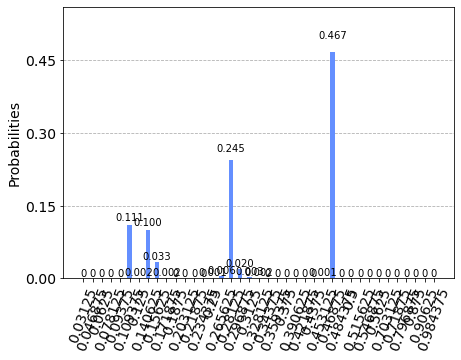

In [28]:
bits = 8
shots_per_vec1 = 100
shots_per_vec2 = 1000
roundoff = 2

pool = ortho_group.rvs(dim=N)
res = None
for i in range(N):
    initial = pool[i]
    if res is None:
        res = qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff)
    else:
        res.merge(qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff))
        
eigval_occurences = res.get_eigvals()
print(eigval_occurences)

#THRESHOLDING

relevant_eigvals = select_eigenvalues(eigval_occurences, bits-roundoff, N)
print(relevant_eigvals)

eigvec_weights = [i/sum(relevant_eigvals) for i in relevant_eigvals]

result = None
for ev,weight in zip(relevant_eigvals,eigvec_weights):
    initial = res.eigvec_from_eigval(ev)
    print(f"Using estimate for {ev}: {initial}, with weight: {weight}")
    if len(initial)==0:
        continue
    if result is None:
        result = qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff)
    else:
        result.merge(qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff))

plot_histogram(result.get_eigvals(False))

In [30]:
K = 4

#RETRIEVE EIGVECTORS ESTIMATES
estimated_eigenvalues = sorted(select_eigenvalues(result.get_eigvals(), bits-roundoff, N))
estimated_eigvals = [i for i in estimated_eigenvalues[-K:]]
print("eigenvalues considered ", estimated_eigvals)
eigenvectors = [result.eigvec_from_eigval(i) for i in estimated_eigenvalues]

eigval_diag = np.diag(estimated_eigvals)
estimated_eigvecs = np.array(eigenvectors[-K:]).T

lowrank_covmat_est = np.matmul(np.matmul(estimated_eigvecs,eigval_diag),estimated_eigvecs.T)
lowrank_covmat = np.matmul(np.matmul(eigvecs[:,-K:],np.diag(eigvals[-K:])),eigvecs[:,-K:].T)
diff = lowrank_covmat_est - lowrank_covmat
print("reconstruction error l2 norm ",np.linalg.norm(diff)/np.linalg.norm(lowrank_covmat))

#VECTORS ORTHOGONALITY
U = np.matmul(estimated_eigvecs.T, estimated_eigvecs)
print("vectors orthogonality error ",np.linalg.norm(U - np.eye(K))/K)

eigenvalues considered  [0.109375, 0.140625, 0.28125, 0.46875]
reconstruction error l2 norm  0.038342349342630914
vectors orthogonality error  0.015628323648280467


In [18]:
print("eigenvalues: ",estimated_eigvals)
err = 0
for i in range(K):
    v1 = result.eigvec_from_eigval(estimated_eigvals[-i-1])
    v2 = eigvecs[:,-i-1]
    d1 = np.linalg.norm(v1-v2)
    d2 = np.linalg.norm(v2+v1)
    err += d1 if d1 < d2 else d2
err /= K
print("average eigenvector error l2 norm: ",err)

eigenvalues:  [0.109375, 0.140625, 0.15625, 0.46875]
average eigenvector error l2 norm:  0.3538375884014342


In [ ]:
print(covmat)